In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from datetime import date
from datetime import timedelta

from yahoofinancials import YahooFinancials

from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

from neuralprophet import NeuralProphet

In [2]:
end = '2021-08-16'
start = '2016-07-20'

In [3]:
stock_symbol = 'TCS.NS'

yf = YahooFinancials(stock_symbol)
data = yf.get_historical_price_data(start, end, 'daily')
TCS = pd.DataFrame(data['TCS.NS']['prices'])
TCS = TCS.drop('date', axis=1).set_index('formatted_date')

TCS['Date'] = pd.to_datetime(TCS.index, format="%Y-%m-%d")
TCS.set_index('Date', drop=False, inplace=True)

df = TCS.dropna()

In [4]:
df

,high,low,open,close,volume,adjclose,Date
Date,,,,,,,
2016-07-20,1251.250000,1224.074951,1225.000000,1247.474976,2815252.0,1129.042114,2016-07-20
2016-07-21,1259.750000,1232.224976,1244.750000,1253.025024,2527148.0,1134.065430,2016-07-21
2016-07-22,1262.000000,1246.000000,1249.449951,1257.550049,1517216.0,1138.160645,2016-07-22
2016-07-25,1281.599976,1252.900024,1256.000000,1279.474976,1688796.0,1161.004517,2016-07-25
2016-07-26,1284.000000,1266.500000,1279.474976,1276.300049,2311290.0,1158.123901,2016-07-26
...,...,...,...,...,...,...,...
2021-08-09,3337.000000,3310.000000,3323.899902,3322.699951,1510489.0,3322.699951,2021-08-09
2021-08-10,3349.899902,3315.600098,3315.600098,3333.899902,2040777.0,3333.899902,2021-08-10
2021-08-11,3360.000000,3327.100098,3350.000000,3344.199951,1929707.0,3344.199951,2021-08-11


In [5]:
data = df[["Date","close"]]

# Rename the features: These names are NEEDED for the model fitting
data = data.rename(columns = {"Date":"ds","close":"y"}) #renaming the columns of the dataset
data.reset_index(drop=True, inplace=True)

In [6]:
data

,ds,y
0,2016-07-20,1247.474976
1,2016-07-21,1253.025024
2,2016-07-22,1257.550049
3,2016-07-25,1279.474976
4,2016-07-26,1276.300049
...,...,...
1245,2021-08-09,3322.699951
1246,2021-08-10,3333.899902
1247,2021-08-11,3344.199951
1248,2021-08-12,3351.750000


In [7]:
# m = NeuralProphet() # default model


m = NeuralProphet(
    n_forecasts=90,
    n_lags=60,
    n_changepoints=50,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    batch_size=5,
    epochs=100,
    learning_rate=0.1,
)

In [8]:
# with cross-validation
metrics = m.fit(data, 
                freq="D",
                valid_p=0.2, # validation proportion of data (20%)
                epochs=100)

INFO - (NP.forecaster._handle_missing_data) - 601 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 601 NaN values in column y were auto-imputed.
Epoch[100/100]: 100%|██████████| 100/100 [01:45<00:00,  1.06s/it, SmoothL1Loss=0.000309, MAE=40.6, MSE=2.84e+3, RegLoss=0]


WARNING - (NP.forecaster.make_future_dataframe) - Insufficient data for 1250 historic forecasts, reduced to 1190.
INFO - (NP.forecaster._handle_missing_data) - 601 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 601 NaN values in column y were auto-imputed.


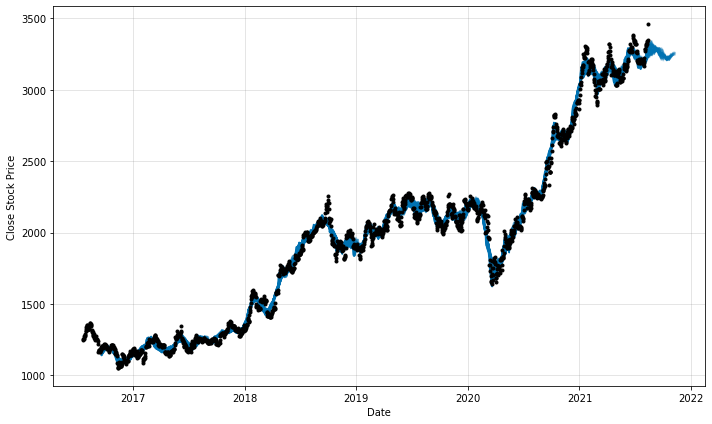

In [9]:
# Predictions
future = m.make_future_dataframe(data, periods=90, n_historic_predictions=len(data)) #we need to specify the number of days in future
prediction = m.predict(future)

# Plotting
forecast = m.plot(prediction)
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

In [10]:
prediction.columns

Index(['ds', 'y', 'yhat1', 'residual1', 'yhat2', 'residual2', 'yhat3',
       'residual3', 'yhat4', 'residual4',
       ...
       'ar85', 'ar86', 'ar87', 'ar88', 'ar89', 'ar90', 'trend',
       'season_yearly', 'season_weekly', 'season_daily'],
      dtype='object', length=276)

In [11]:
prediction

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,ar85,ar86,ar87,ar88,ar89,ar90,trend,season_yearly,season_weekly,season_daily
0,2016-07-20,1247.474976,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2016-07-21,1253.025024,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2016-07-22,1257.550049,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2016-07-23,1264.858358,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2016-07-24,1272.166667,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,2021-11-07,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,391.672058,384.089447,384.222168,386.209534,379.677124,3080.927246,-26.909603,0.026714,-189.731934
1937,2021-11-08,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,397.946747,384.389893,387.348145,387.687988,3081.084473,-28.863815,0.683917,-189.731934
1938,2021-11-09,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,399.338837,387.270477,384.713348,3081.242188,-30.746954,1.150703,-189.731934
1939,2021-11-10,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,399.79895,382.567627,3081.399414,-32.553322,1.186685,-189.731934


In [12]:
pred = pd.DataFrame()

In [13]:
pred['date'] = prediction['ds']
pred['pred'] = prediction['ar90'] + prediction['trend'] + prediction['season_yearly'] + prediction['season_weekly'] + prediction['season_daily']

In [14]:
pred

,date,pred
0,2016-07-20,NaN
1,2016-07-21,NaN
2,2016-07-22,NaN
3,2016-07-23,NaN
4,2016-07-24,NaN
...,...,...
1936,2021-11-07,3243.989548
1937,2021-11-08,3250.860629
1938,2021-11-09,3246.627351
1939,2021-11-10,3242.868471


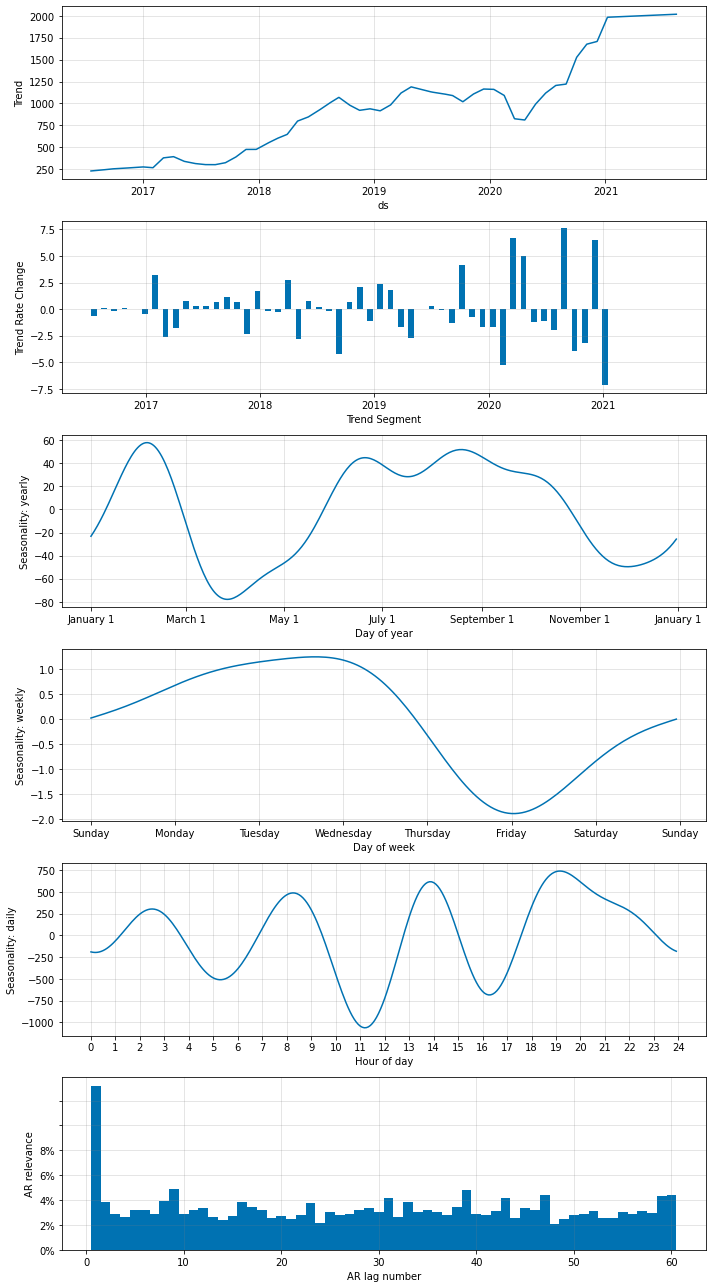

In [15]:
fig_param = m.plot_parameters()

In [16]:
# fig_comp = m.plot_components(prediction)

In [17]:
# prediction.to_csv('pred.csv')